Compare Noise Between Several Seismic/Acoustic Sites Using Probabilistic Power Spectral Densities (PPSD)
--

Compare noise across several sites to determine whichi is 'best' or 'worst'.

In [85]:
#import modules
from obspy.core import read, Trace, Stream, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal import PPSD
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

**GeoNet's FDSN web servers**

In [86]:
arc_client = 'http://service.geonet.org.nz'
nrt_client = 'http://beta-service-nrt.geonet.org.nz'

**Functions**

In [87]:
#function to get a stream from a FDSN client
def dayswave(date1, date2, net, sta, loc, cmp):
  #get data from a FDSN web server for days date1 to date2 inclusive
  global st
  time1 = UTCDateTime(date1)
  time2 = UTCDateTime(date2)
  #st = client.get_waveforms(net, sta, loc, cmp, time1, time2 + 86400, attach_response=True)
  try:
    client = Client(arc_client)
    st = client.get_waveforms(net, sta, loc, cmp, time1, time2 + 86400)
    print ('arc client successful')
    #if this raises an exception, try the near real-time server
  except:
    client = Client(nrt_client)
    st = client.get_waveforms(net, sta, loc, cmp, time1, time2 + 86400)
    print ('nrt client successful')

In [88]:
#function to get response from a FDSN client
def getresp(date1, date2, net, sta, loc, cmp):
  global inventory
  try:
    client = Client(arc_client)
    inventory = client.get_stations(network=net, station=sta, channel=cmp, location=loc, starttime=UTCDateTime(date1), endtime=UTCDateTime(date2)+86400, level='response')
    print ('arc client successful')
    #if this raises an exception, try the near real-time server
  except:
    client = Client(nrt_client)
    inventory = client.get_stations(network=net, station=sta, channel=cmp, location=loc, starttime=UTCDateTime(date1), endtime=UTCDateTime(date2)+86400, level='response')
    print ('nrt client successful')
  

**Date range**

In [89]:
date1 = '2017-11-09'
date2 = '2017-11-09'

**Sites**

In [90]:
sites = ['WHTZ.10.EHZ.NZ','POIZ.10.EHZ.NZ','ARAZ.10.EHZ.NZ','KUTZ.10.EHZ.NZ','WPRZ.10.EHZ.NZ']

**Loop through sites calculating PPSD**

In [91]:
#empty dataframe for ppsd results
df = pd.DataFrame()

for site in sites:
    sta, loc, cmp, net = site.split('.')[0:5]
       
    #get data stream
    dayswave(date1, date2, net, sta, loc, cmp)
    tr = st[0]
    print tr

    #get response, separately
    getresp(date1, date2, net, sta, loc, cmp)

    #ppsd
    ppsd = PPSD(tr.stats, metadata=inventory)
    ppsd.add(st)
    #ppsd.plot(show_coverage=False)
    #extract mean data
    mean = ppsd.get_mean()
    frequency = 1/mean[0]
    amplitude = mean[1]
    #populate dataframe
    data = pd.DataFrame()
    data['frequency'] = frequency
    data['amplitude'] = amplitude
    data['site'] = site
    df = df.append(data)

arc client successful
NZ.WHTZ.10.EHZ | 2017-11-08T23:59:55.372732Z - 2017-11-09T01:51:06.122732Z | 100.0 Hz, 667076 samples
arc client successful
arc client successful
NZ.POIZ.10.EHZ | 2017-11-08T23:59:58.518391Z - 2017-11-09T01:51:06.858391Z | 100.0 Hz, 666835 samples
arc client successful
arc client successful
NZ.ARAZ.10.EHZ | 2017-11-08T23:59:58.128396Z - 2017-11-09T01:51:07.808396Z | 100.0 Hz, 666969 samples
arc client successful
arc client successful
NZ.KUTZ.10.EHZ | 2017-11-08T23:59:54.628393Z - 2017-11-09T01:51:05.958393Z | 100.0 Hz, 667134 samples
arc client successful
arc client successful
NZ.WPRZ.10.EHZ | 2017-11-08T23:59:57.898391Z - 2017-11-09T01:51:05.958391Z | 100.0 Hz, 666807 samples
arc client successful


In [92]:
ppsdmean = pd.pivot_table(df, index='frequency', columns='site')

In [103]:
ppsdmean.head()

amplitude                                               \
site      ARAZ.10.EHZ.NZ KUTZ.10.EHZ.NZ POIZ.10.EHZ.NZ WHTZ.10.EHZ.NZ   
frequency                                                               
0.001526      -65.138298     -65.095745     -68.202128     -67.223404   
0.001664      -65.138298     -65.095745     -68.202128     -67.223404   
0.001815      -65.138298     -65.095745     -68.202128     -67.223404   
0.001979      -65.138298     -65.095745     -68.202128     -67.223404   
0.002158      -65.138298     -65.095745     -68.202128     -67.223404   

                          
site      WPRZ.10.EHZ.NZ  
frequency                 
0.001526     -110.755319  
0.001664     -110.755319  
0.001815     -110.755319  
0.001979     -110.755319  
0.002158     -110.755319

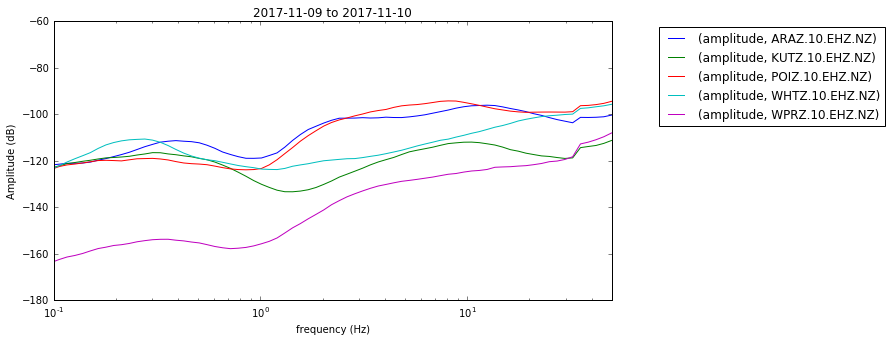

In [100]:
pl = ppsdmean.plot(figsize=(10, 5), logx=True)
pl.set_xlim(0.1,50)
pl.set_xlabel('frequency (Hz)')
pl.set_ylabel('Amplitude (dB)')
pl.legend(bbox_to_anchor=(1.5, 1))
#title
d1 = UTCDateTime(date1)
d2 = UTCDateTime(date2)+86400
pl.set_title(str(d1.date)+' to '+str(d2.date))